In [2]:
import glob
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from math import log, pi, exp
from tqdm import tqdm

In [54]:
data_dir = "D://datasets//faces"
batch_size = 32

class MyImageDataset(Dataset):
    def __init__(self, fnames):
        self.fnames = fnames
        self.num_samples = len(self.fnames)
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((64,64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5), std=(0.5))
        ])

    def __getitem__(self, idx):
        fnames = self.fnames[idx]
        img = PIL.Image.open(fnames)
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples

def get_dataset(root):
    fnames = glob.glob(os.path.join(root, "*"))
    return MyImageDataset(fnames)


dataset = get_dataset(data_dir)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

torch.Size([64, 64, 1])


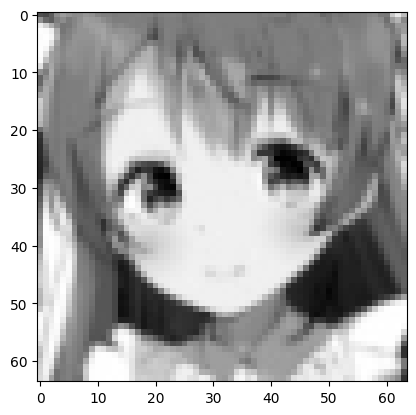

In [120]:
# test
test_img = None
for data in dataloader:
    test_img = data
    break

test_img = test_img[0].permute(1, 2, 0)
print(test_img.shape)
plt.imshow(test_img, cmap="gray")

In [3]:
num_steps = 200
beta = torch.linspace(-6, 6, num_steps)
beta = torch.sigmoid(beta) * 0.055

alpha = 1 - beta
alpha_tilde = torch.cumprod(alpha, dim=0)
alpha_tilde_prev = torch.cat([torch.ones(1), alpha_tilde[:-1]], dim=0)
alpha_tilde_sqrt = torch.sqrt(alpha_tilde)
one_minus_alpha_tilde_sqrt = torch.sqrt(1-alpha_tilde)

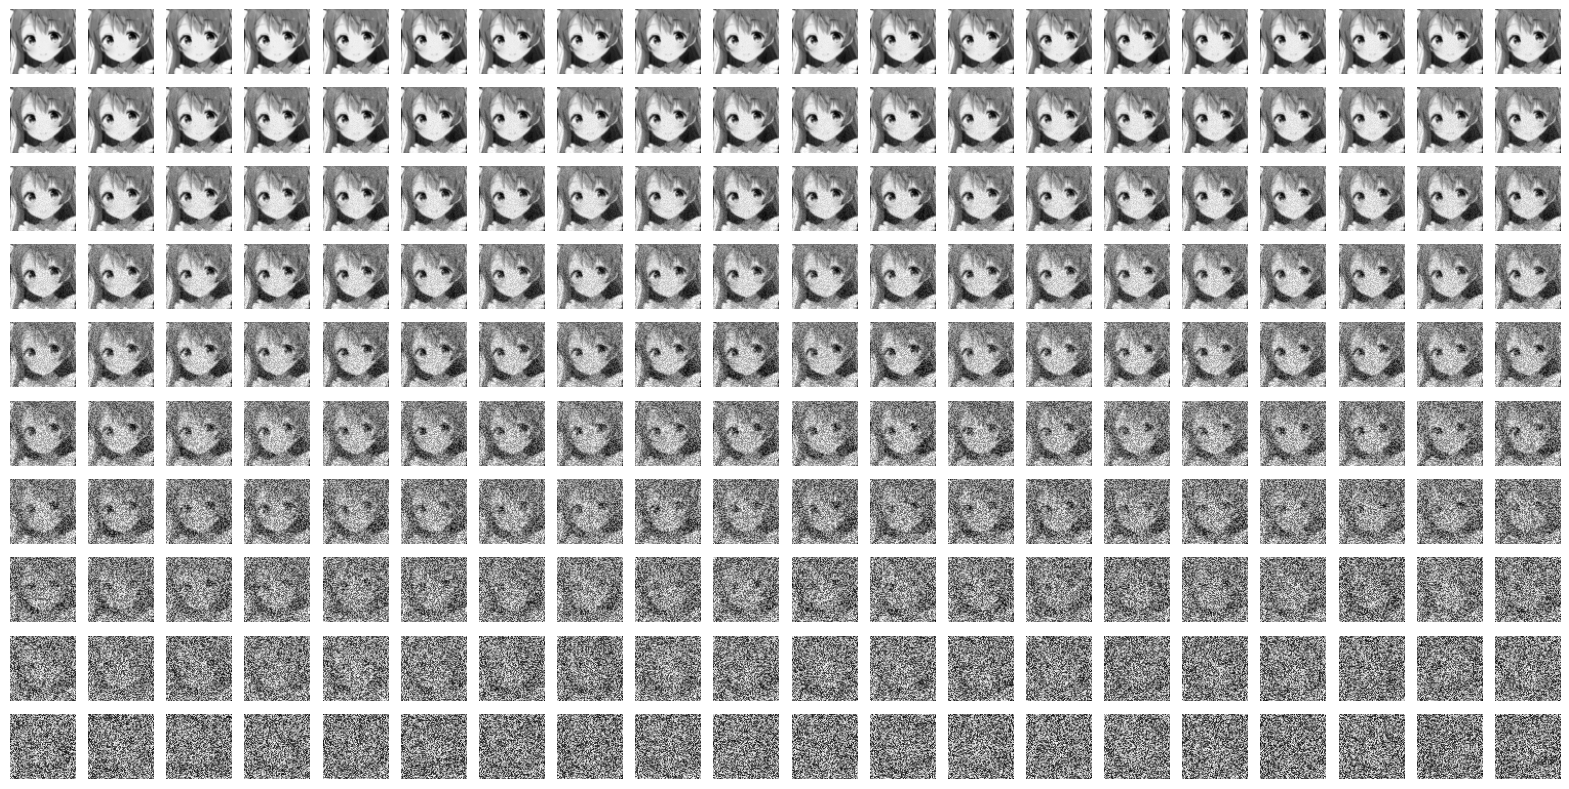

In [143]:
# test
def get_xt(x0, t):
    return x0 * alpha_tilde_sqrt[t] + torch.rand_like(x0) * one_minus_alpha_tilde_sqrt[t]

rows = 10
cols = num_steps // rows
fig, axs = plt.subplots(rows, cols, figsize=(20, 10))

for step in range(0, num_steps):
    noisy_image = get_xt(test_img, step)
    axs[step // cols][step % cols].imshow(noisy_image, cmap='gray')
    axs[step // cols][step % cols].set_axis_off()

In [5]:
class PredictNoise(nn.Module):
    def __init__(self, n_steps, n_channels, hidden_dim=256):
        super(PredictNoise, self).__init__()
        
        self.linear1 = nn.Linear(n_channels, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, n_channels)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        
        self.step_embedding1 = nn.Embedding(n_steps, hidden_dim)
        self.step_embedding2 = nn.Embedding(n_steps, hidden_dim)
        self.step_embedding3 = nn.Embedding(n_steps, hidden_dim)
        
    # We use xt and step t to predict the noise
    # !!! Note that the noise is not the one added from xt-1 to xt. It is the combination of many noise.
    def forward(self, xt, t):
        x = self.linear1(xt)
        x = x + self.step_embedding1(t)
        x = self.relu1(x)
        
        x = self.linear2(x)
        x = x + self.step_embedding2(t)
        x = self.relu2(x)
        
        x = self.linear3(x)
        x = x + self.step_embedding3(t)
        x = self.relu3(x)
        
        x = self.linear4(x)

        return x
    
model = PredictNoise(200, 2)

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

loss_list = []
iters = 10
for iter in range(iters):
    iter_loss = 0
    for data in tqdm(dataloader):
        x0 = data
        t = torch.randperm(200)[:batch_size]
        a = alpha_tilde_sqrt[t]
        one_minus_a = one_minus_alpha_tilde_sqrt[t]

        # generate a random noise as target
        epsilon = torch.rand_like(x0)
        # now we predict it given xt and t
        xt = a * x0 + one_minus_a * epsilon
        epsilon_theta = model(xt, t)

        loss = ((epsilon_theta - epsilon) ** 2).sum() / batch_size
        iter_loss += loss.data
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
#     if iter %= 100:
#         sample = generate_image()
#         plt.figure(iter)
#         plt.plot()
    loss_list.append(iters)

TypeError: 'int' object is not iterable

In [7]:
def generate_image():
    cur_x = torch.rand(1, 64, 64)
    for t in reversed(range(num_steps)):
        epsilon_theta = model(cur_x, t)
        mu_theta = 1 / alpha_tilde_sqrt[t] * (cur_x - beta[t] / one_minus_alpha_tilde_sqrt * epsilon_theta)
        # sample
        cur_x = mu_theta + torch.randn_like(cur_x) * betas[t].sqrt()   # the value betas[t].sqrt() is hold fixed
    return cur_x

generate_image()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x64 and 2x256)

In [10]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch
import torch.nn as nn

s_curve, _ = make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]] / 10.0
dataset = torch.Tensor(s_curve).float()

  8%|██████                                                                         | 309/4000 [02:18<27:39,  2.22it/s]


KeyboardInterrupt: 

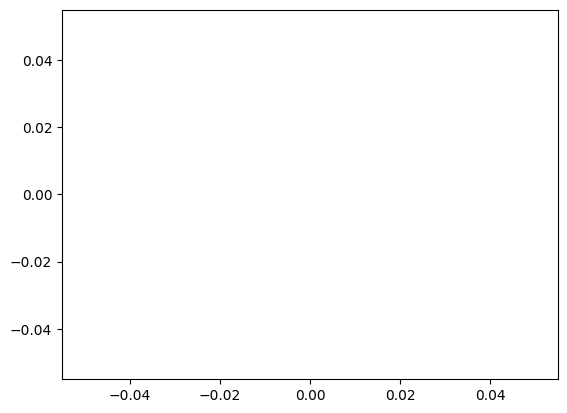

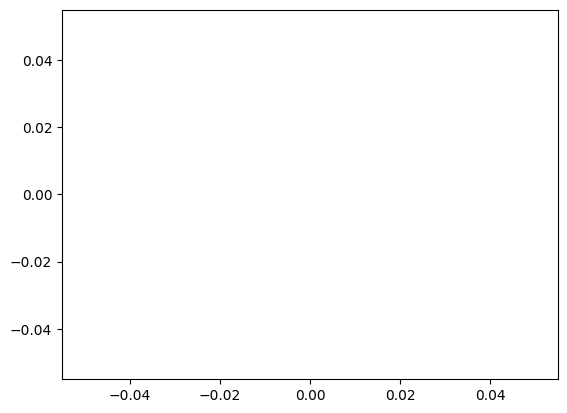

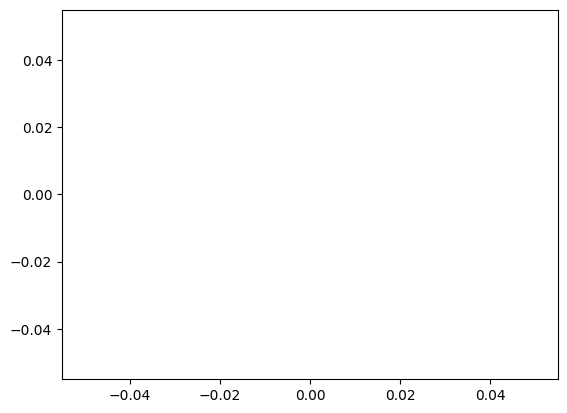

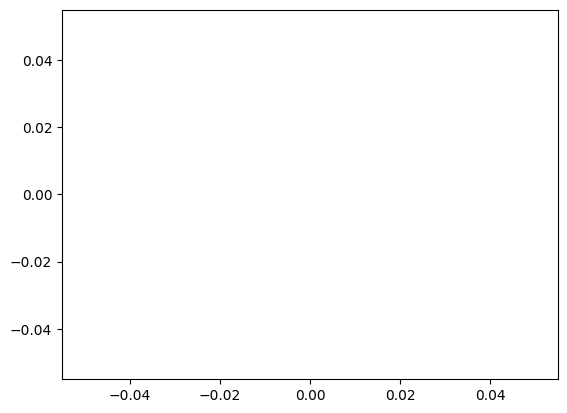

In [14]:
def generate_image():
    cur_x = torch.rand(1000, 2)
    for t in reversed(range(num_steps)):
        epsilon_theta = model(cur_x, torch.tensor([t]))
        mu_theta = 1 / alpha_tilde_sqrt[t] * (cur_x - beta[t] / one_minus_alpha_tilde_sqrt[t] * epsilon_theta)
        # sample
        cur_x = mu_theta + torch.randn_like(cur_x) * beta[t].sqrt()   # the value beta[t].sqrt() is hold fixed
    return cur_x

batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model = PredictNoise(200, 2)

loss_list = []
iters = 4000
for iter in tqdm(range(iters)):
    iter_loss = 0
    for data in dataloader:
        x0 = data
        
        t = torch.randperm(200)[:batch_size]
        a = alpha_tilde_sqrt[t].unsqueeze(-1)
        one_minus_a = one_minus_alpha_tilde_sqrt[t].unsqueeze(-1)

        # generate a random noise as target
        epsilon = torch.rand_like(x0)
        # now we predict it given xt and t
        xt = a * x0 + one_minus_a * epsilon
        epsilon_theta = model(xt, t)

        loss = ((epsilon_theta - epsilon) ** 2).sum() / batch_size
        iter_loss += loss.data
        
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
       
    loss_list.append(iter_loss)
    if iter % 100 == 0:
        sample = generate_image().detach().numpy()
        plt.figure(iter)
        plt.scatter(sample[:, 0], sample[:, 1])
        

plt.show()


[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]


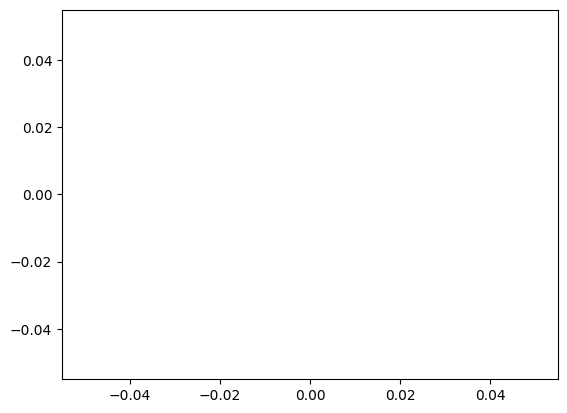

In [16]:
img = generate_image().detach().numpy()
print(img)
plt.scatter(img[:, 0], img[:, 1])